# Clustering 5.7 million RNA sequences of coronavirus

In this demo we use CLASSIX [3] to cluster a dataset accompanying the paper [1]. The data corresponds to PaCMAP low dimensional (3D) projections of two characterisations (3-mer count and Extended Natural Vector) of about 5.7 million high coverage sequences of SARS-CoV-2 from the publicly available [GISAID database](https://gisaid.org/). The PaCMAP parameters were optimized by a search over a 3x3x3 grid, selecting the best clustering of a stratified data subsample (5% of the data). 

The paper [1] also compares CLASSIX to HDBSCAN [2], with the timings and achieved adjusted Rand index (ARI) and adjusted mutual information (AMI) shown in the below table.
<div style="max-width:600px;">
    
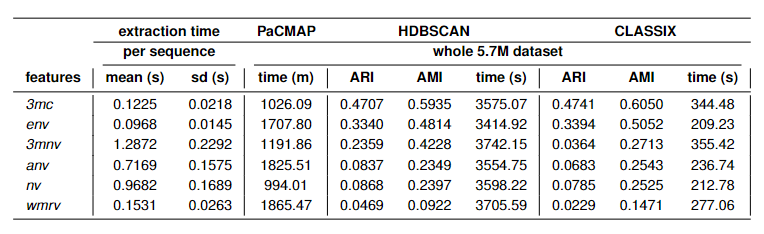

</div>

Note how CLASSIX was more than 10x faster than HDSCAN and achieved better AMI on all but one instance. These timings were obtained with an old version of CLASSIX (0.6.5). The newer CLASSIX versions since then are even faster. As we will demonstrate below, **CLASSIX is more than 400 times faster than HDBSCAN for this dataset, while achieving higher ARI/AMI.** 

Let's recreate the first line in the above table with a more recent CLASSIX version. First, we load the data as a dataframe together with the ground-truth labels.

In [1]:
import classix
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.preprocessing import MinMaxScaler
from time import time
import pandas as pd
import numpy as np
import os

# note that first data load can take a few minutes as downloaded from web
data, labels = classix.loadData('Covid3MC') # alternatively, try 'CovidENV'

# min-max scale data and center data as in
# https://github.com/robcah/dimredcovid19/blob/main/Dimensionality_Reduction_Covid19.ipynb
data[['PaCMAP_0','PaCMAP_1','PaCMAP_2']] = MinMaxScaler().fit_transform(data)-0.5
data

,PaCMAP_0,PaCMAP_1,PaCMAP_2
taxon,,,
hCoV-19/USA/ID-IBL-768927/2021,0.085946,-0.235907,-0.063633
hCoV-19/England/BRBR-27EF0BF/2021,-0.192715,-0.176919,0.222588
hCoV-19/England/NORT-YYIN5H/2021,0.144570,-0.242236,-0.012213
hCoV-19/England/ALDP-188CEBC/2021,-0.019368,-0.243894,0.040634
hCoV-19/Israel/CVL-17696/2021,-0.036867,-0.154339,-0.379922
...,...,...,...
hCoV-19/Denmark/DCGC-409585/2022,0.205253,0.221218,0.297684
hCoV-19/Luxembourg/LNS1793723/2021,-0.100150,0.188429,-0.064979
hCoV-19/Denmark/DCGC-410683/2022,0.112713,0.136118,0.421180


## CLASSIX

Now we are ready to run CLASSIX. As in [1], we use the hyperparameters `radius=0.2` and `minPts=500`.

In [7]:
print("CLASSIX version:", classix.__version__)
st = time()
clx = classix.CLASSIX(radius=0.2, minPts=500, verbose=0);
clx.fit(data)
et = time() - st
print("CLASSIX time:", et, "seconds")
print("CLASSIX ARI: ", ari(labels,clx.labels_))
print("CLASSIX AMI: ", ami(labels,clx.labels_))
#clx.clusterSizes_

CLASSIX version: 1.0.5
CLASSIX time: 7.690809011459351 seconds
CLASSIX ARI:  0.47408208847538585
CLASSIX AMI:  0.6050383300287772


This took less than 8 seconds! Our machine is a Dell PowerEdge R740 Server with two Intel Xeon Silver 4114 2.2G processors, 1,536 GB RAM, and 1.8 TB disk space. Everything runs in one thread.

## HDBSCAN

We can compare this to HDBSCAN, using the same parameters as in [1]. The runtime is significantly longer, in the order of an hour!

In [3]:
import hdbscan
st = time()
_hdbscan = hdbscan.HDBSCAN(min_cluster_size=180000, min_samples=5)
hdbscan_labels = _hdbscan.fit_predict(data)
et = time() - st
print("HDBSCAN time:", et, "seconds")
print("HDBSCAN ARI: ", ari(labels,hdbscan_labels))
print("HDBSCAN AMI: ", ami(labels,hdbscan_labels))

HDBSCAN time: 4079.301036119461 seconds
HDBSCAN ARI:  0.4707345716634707
HDBSCAN AMI:  0.5934570743288409


## CLASSIX's explain function

Alongside being super fast, another feature of CLASSIX is its **explainability.** We can use the `.explain()` method to explore the clustering in more detail. For example, we can ask why two specific RNA sequences have been clustered together:

Too many data points for plot. Randomly subsampled 1e5 points.
With data having more than two features, the group circles in
the plot may appear bigger than they are.


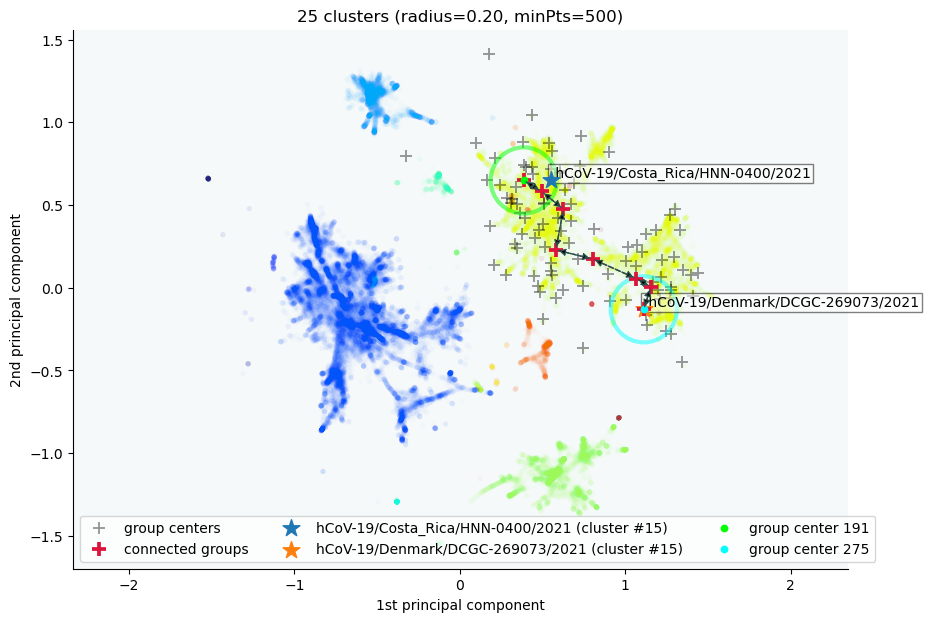

Data point hCoV-19/Costa_Rica/HNN-0400/2021 is in group 191.
Data point hCoV-19/Denmark/DCGC-269073/2021 is in group 275.
Both groups were merged into cluster #15. 

The two groups are connected via groups
 191 <-> 210 <-> 239 <-> 230 <-> 258 <-> 272 <-> 279 <-> 275.

Here is a list of connected data points with
their global data indices and group numbers:

   Index  Group                                Label
    160    191     hCoV-19/Costa_Rica/HNN-0400/2021
3635328    191      hCoV-19/Denmark/DCGC-53908/2021
4236125    210         hCoV-19/Canada/AB-69846/2020
1375897    239  hCoV-19/Switzerland/VD-GEN2686/2020
2339407    230    hCoV-19/Hong_Kong/VM21014172/2021
 124617    258 hCoV-19/USA/NY-CDC-ASC210065048/2021
4068000    272   hCoV-19/Luxembourg/LNS7664614/2021
5062976    279      hCoV-19/USA/WI-WSLH-214678/2021
1648495    275     hCoV-19/Denmark/DCGC-269073/2021
1648495    275     hCoV-19/Denmark/DCGC-269073/2021 



In [4]:
clx.explain('hCoV-19/Costa_Rica/HNN-0400/2021', 'hCoV-19/Denmark/DCGC-269073/2021', plot=True, alpha=0.01)

CLASSIX explains that there is a path of nearby data points in cluster #15 that brings us from one virus RNA (index 160 in the dataset) to the other (index 1648495). The last data point 1648495 happens to be a group center, which is why it's listed twice. We can verify that the distances of neighboring data points on the path are indeed small:

In [5]:
ind1, ind2 = 160, 1648495
path = list(clx.getPath(ind1,ind2))
for i in range(len(path)-1):
    i1, i2 = path[i], path[i+1]
    p1, p2 = data.iloc[i1].to_numpy(), data.iloc[i2].to_numpy()
    dist = np.linalg.norm(p1-p2)
    print("Distance between data point {:7} and {:7}: {:5.4f}".format(i1,i2,dist))

print("\nMaximal allowed distance between points on path: {:5.4f}".format(clx.radius*clx.dataScale*clx.mergeScale))

Distance between data point     160 and 3635328: 0.0598
Distance between data point 3635328 and 4236125: 0.0669
Distance between data point 4236125 and 1375897: 0.0789
Distance between data point 1375897 and 2339407: 0.0860
Distance between data point 2339407 and  124617: 0.0946
Distance between data point  124617 and 4068000: 0.0999
Distance between data point 4068000 and 5062976: 0.0685
Distance between data point 5062976 and 1648495: 0.0817
Distance between data point 1648495 and 1648495: 0.0000

Maximal allowed distance between points on path: 0.1000


The maximal allowed distance between the data points is `clx.radius*clx.dataScale*clx.mergeScale = 0.1`. The parameter `clx.radius=0.2` is what we have chosen above. The parameter `clx.dataScale` is a data scaling factor that is automatically determined by CLASSIX to make the clustering scaling-invariant and less sensitive to the choice of `radius`. The parameter `clx.mergeScale=1.5` controls the merging of groups into clusters and normally does not need to be changed.

## Making our own 3D scatter plot

CLASSIX's explain method can produce 2D plots of the data. In some cases it is desirable to plot the data in 3D. This is also the case here, as the data is actually three-dimensional. We can easily generate our own explain plot using the CLASSIX properties `.groupCenters_` and `.clusterSizes_`, as well as the `.getPath()` method.

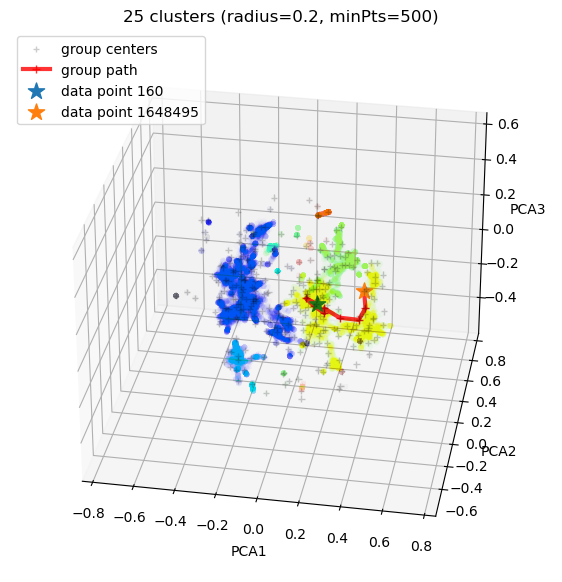

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from random import sample
# PCA into 3-dimension (could be skipped as data is already 3-dim)
pca = PCA(n_components=3)
data3 = pca.fit_transform(data)
ind = range(data.shape[0])
if data.shape[0] > 1e5: # subsample if too many pts
    ind = sample(ind, 100000)
ind1, ind2 = 160, 1648495 # indices of the two data points to highlight
path = list(clx.getPath(ind1,ind2))
gc = list(clx.groupCenters_)
# do all the plotting
fig = plt.figure(figsize=(7,9))
ax = fig.add_subplot(projection='3d')
ax.scatter(data3[ind,0],data3[ind,1],data3[ind,2],c=clx.labels_[ind],alpha=0.002,cmap='jet',linewidths=0);
ax.scatter(data3[gc,0],data3[gc,1],data3[gc,2],marker='+',c='k',linewidth=1,alpha=0.2,label='group centers');
ax.plot(data3[path,0],data3[path,1],data3[path,2],marker='+',c='r',alpha=0.8,linewidth=3,label='group path');
ax.scatter(data3[ind1,0],data3[ind1,1],data3[ind1,2],marker='*',s=150,label='data point ' + str(ind1));
ax.scatter(data3[ind2,0],data3[ind2,1],data3[ind2,2],marker='*',s=150,label='data point ' + str(ind2));
ax.view_init(30, -80)
plt.axis('equal'), plt.xlabel('PCA1'), plt.ylabel('PCA2'), ax.set_zlabel('PCA3')
plt.title('{} clusters (radius={}, minPts={})'.format(len(clx.clusterSizes_),clx.radius,clx.minPts))
plt.legend(loc='upper left');

### References

[1]  R. Cahuantzi, K. Lythgoe, I. Hall, L. Pellis, and T. House. "Unsupervised identification of significant lineages of SARS-CoV-2 through scalable machine learning methods." bioRxiv 2022.09.14.507985, 2022. (https://doi.org/10.1101/2022.09.14.507985)

[2] X. Chen and S. Güttel. "Fast and explainable clustering based on sorting." arXiv: https://arxiv.org/abs/2202.01456, 2022.

[3] L. McInnes, J. Healy, and S. Astels. "hdbscan: Hierarchical density based clustering." Journal of Open Source Software 2.11 (2017): 205.